In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle                      
import cv2                                 
import tensorflow as tf   



In [3]:
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (50, 50)

def load_data():
    datasets = ['C:\\Users\\smedy\\OneDrive\\Pulpit\\suml\\archive\\images\\images\\train\\']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            count = 0
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                # Open and resize the img
#                 image = cv2.imread(img_path)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#                 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
                # Taking 2k images from of each type because of MemoryError
                count = count + 1
                if count == 2000:
                    break
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))
        return output

In [4]:
(images, labels) = load_data()[0]

Loading C:\Users\smedy\OneDrive\Pulpit\suml\archive\images\images\train\


 62%|██████▏   | 1999/3205 [00:29<00:17, 68.79it/s]


In [5]:
permutation  = np.random.permutation(len(images))

shuffled_images = images[permutation]
shuffled_labels = labels[permutation]

In [6]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(shuffled_images, shuffled_labels, test_size=0.1, shuffle=True)

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((11192, 50, 50), (11192,), (1244, 50, 50), (1244,))

In [7]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

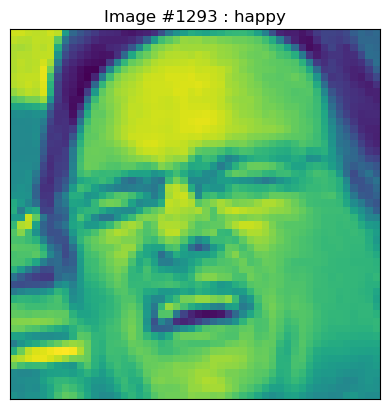

In [8]:
def display_random_image(class_names, images, labels):   
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image(class_names, train_images, train_labels)

In [9]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (50, 50, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(7, activation='softmax')
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

c:\Users\smedy\miniconda3\envs\ag\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 22, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,527 (451.28 KB)

 Trainable params: 115,047 (449.40 KB)

 Non-trainable params: 480 (1.88 KB)

In [10]:
history = model2.fit(train_images, train_labels, epochs=30, validation_split = 0.1)

Epoch 1/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.1973 - loss: 2.1918 - val_accuracy: 0.1527 - val_loss: 2.0005
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.2705 - loss: 1.8030 - val_accuracy: 0.2634 - val_loss: 1.9617
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.3298 - loss: 1.6940 - val_accuracy: 0.3661 - val_loss: 1.6186
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - accuracy: 0.3621 - loss: 1.6151 - val_accuracy: 0.3866 - val_loss: 1.5809
Epoch 5/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - accuracy: 0.3864 - loss: 1.5736 - val_accuracy: 0.4089 - val_loss: 1.5350
Epoch 6/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.3987 - loss: 1.5204 - val_accuracy: 0.4223 - val_loss: 1.5113
Epoch 7/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.4262 - loss: 1.4918 - val_accuracy: 0.3795 - val_loss: 1.6162
Epoch 8/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.4421 - loss: 1.4323 - 

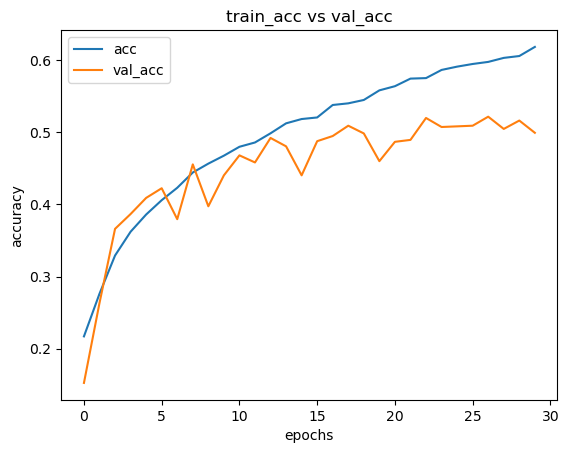

In [11]:
plt.plot(history.history['accuracy'], label = "acc")
plt.plot(history.history['val_accuracy'], label = "val_acc")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


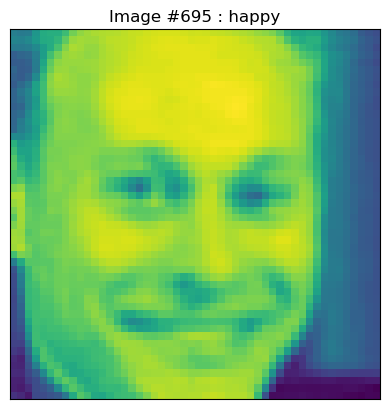

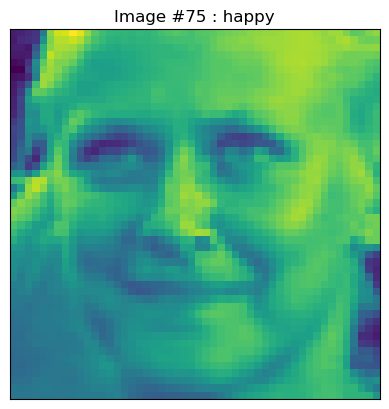

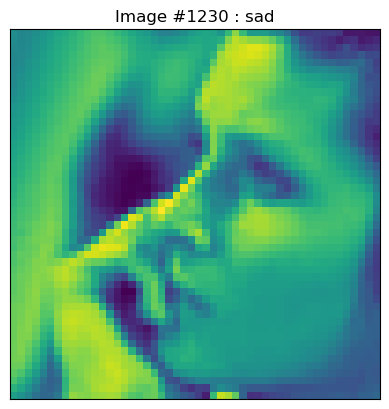

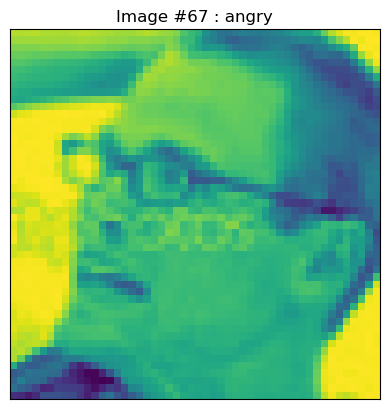

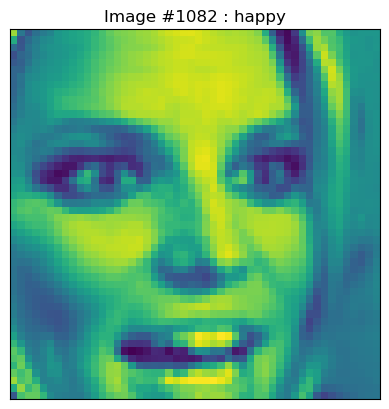

In [14]:
predictions = model2.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

# Display predicted labels
for i in range(5):
    display_random_image(class_names, test_images, pred_labels) 